## **Feature:** [FEATURE_NAME]

**Names:** [YOUR_NAME]

### **What it does**
[Brief description]

### **Helper Functions**
[List Helper Functions]

In [9]:
import numpy as np
import pandas as pd


In [10]:
def zscore_outliers_mask(s: pd.Series, z_thresh: float = 3.0) -> pd.Series:
    """True where |z| > z_thresh; safe for zero/NaN std."""
    if not pd.api.types.is_numeric_dtype(s):
        return pd.Series(False, index=s.index)
    x = s.astype(float)
    mu = x.mean(skipna=True)
    sd = x.std(skipna=True)
    if not np.isfinite(sd) or sd == 0:
        return pd.Series(False, index=s.index)
    z = (x - mu) / sd
    return z.abs() > z_thresh

def iqr_bounds(s: pd.Series, k: float = 1.5):
    x = s.astype(float)
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr

def iqr_outliers_mask(s: pd.Series, k: float = 1.5) -> pd.Series:
    if not pd.api.types.is_numeric_dtype(s):
        return pd.Series(False, index=s.index)
    low, high = iqr_bounds(s, k)
    x = s.astype(float)
    return (x < low) | (x > high)


In [11]:
def zscore_report(df: pd.DataFrame, z_thresh=3.0):
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    rows = len(df)
    records = []
    for c in numeric_cols:
        m = zscore_outliers_mask(df[c], z_thresh)
        records.append({
            "column": c,
            "z_thresh": z_thresh,
            "outliers": int(m.sum()),
            "rows": rows,
            "pct_outliers": round(100*m.mean(), 3)
        })
    return pd.DataFrame(records)

def iqr_report(df: pd.DataFrame, iqr_k=1.5):
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    rows = len(df)
    records = []
    for c in numeric_cols:
        m = iqr_outliers_mask(df[c], iqr_k)
        low, high = iqr_bounds(df[c], iqr_k)
        records.append({
            "column": c,
            "iqr_k": iqr_k,
            "lower_bound": low,
            "upper_bound": high,
            "outliers": int(m.sum()),
            "rows": rows,
            "pct_outliers": round(100*m.mean(), 3)
        })
    return pd.DataFrame(records)


In [12]:
df = pd.read_csv("cleaned_smoke.csv")

print("=== Z-score Outliers ===")
print(zscore_report(df, z_thresh=3.0))

print("\n=== IQR Outliers ===")
print(iqr_report(df, iqr_k=1.5))


=== Z-score Outliers ===
            column  z_thresh  outliers  rows  pct_outliers
0             Year       3.0         1   876         0.114
1   Smoke everyday       3.0         4   876         0.457
2  Smoke some days       3.0         5   876         0.571
3    Former smoker       3.0         5   876         0.571
4     Never smoked       3.0        21   876         2.397

=== IQR Outliers ===
            column  iqr_k  lower_bound  upper_bound  outliers  rows  \
0             Year    1.5  1987.000000  2019.000000         1   876   
1   Smoke everyday    1.5     0.061000     0.269000        11   876   
2  Smoke some days    1.5     0.022125     0.075125        28   876   
3    Former smoker    1.5     0.179500     0.311500        63   876   
4     Never smoked    1.5     0.433875     0.638875        47   876   

   pct_outliers  
0         0.114  
1         1.256  
2         3.196  
3         7.192  
4         5.365  


In [13]:
def zscore_outliers_rows(df: pd.DataFrame, z_thresh=3.0) -> pd.DataFrame:
    """
    Return all rows where ANY numeric column is an outlier by Z-score.
    """
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        return pd.DataFrame()  # no numeric columns
    
    mask_union = pd.Series(False, index=df.index)
    for c in numeric_cols:
        mask_union |= zscore_outliers_mask(df[c], z_thresh)
    
    return df.loc[mask_union]

def iqr_outliers_rows(df: pd.DataFrame, iqr_k=1.5) -> pd.DataFrame:
    """
    Return all rows where ANY numeric column is an outlier by IQR.
    """
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        return pd.DataFrame()
    
    mask_union = pd.Series(False, index=df.index)
    for c in numeric_cols:
        mask_union |= iqr_outliers_mask(df[c], iqr_k)
    
    return df.loc[mask_union]


In [21]:
df = pd.read_csv("cleaned_smoke.csv")

print("=== Z-score Report ===")
print(zscore_report(df, z_thresh=3.0))

print("\n=== Outlier Rows by Z-score ===")

print(len(zscore_outliers_rows(df, z_thresh=3.0)))
print(zscore_outliers_rows(df, z_thresh=3.0).head(10))  


print("\n=== IQR Report ===")
print(iqr_report(df, iqr_k=1.5))

print("\n=== Outlier Rows by IQR ===")
print(len(iqr_outliers_rows(df, iqr_k=1.5)))
print(iqr_outliers_rows(df, iqr_k=1.5).head(10))  # show first 10


=== Z-score Report ===
            column  z_thresh  outliers  rows  pct_outliers
0             Year       3.0         1   876         0.114
1   Smoke everyday       3.0         4   876         0.457
2  Smoke some days       3.0         5   876         0.571
3    Former smoker       3.0         5   876         0.571
4     Never smoked       3.0        21   876         2.397

=== Outlier Rows by Z-score ===
30
     Year           State  Smoke everyday  Smoke some days  Former smoker  \
3    2100        Arkansas           0.173            0.056          0.241   
6    2010     Connecticut           0.092            0.040          1.050   
48   2010            Utah           0.064            0.027          0.143   
51   2010  Virgin Islands           0.036            0.022          0.105   
67   2009            Guam           0.189            0.052          0.111   
98   2009     Puerto Rico           0.069            0.037          0.180   
104  2009            Utah           0.069       

In [15]:
def outlier_percent_tables(
    df: pd.DataFrame,
    z_thresh: float = 3.0,
    iqr_k: float = 1.5,
):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    rows = len(df)

    # Z-score table
    z_records = []
    for c in num_cols:
        m = zscore_outliers_mask(df[c], z_thresh)
        z_records.append({
            "column": c,
            "z_thresh": z_thresh,
            "outliers": int(m.sum()),
            "rows": rows,
            "pct_outliers": round(100 * m.mean(), 3),
        })
    z_table = pd.DataFrame(z_records).sort_values("pct_outliers", ascending=False)

    # IQR table
    iqr_records = []
    for c in num_cols:
        m = iqr_outliers_mask(df[c], iqr_k)
        low, high = iqr_bounds(df[c], iqr_k)
        iqr_records.append({
            "column": c,
            "iqr_k": iqr_k,
            "lower_bound": float(low),
            "upper_bound": float(high),
            "outliers": int(m.sum()),
            "rows": rows,
            "pct_outliers": round(100 * m.mean(), 3),
        })
    iqr_table = pd.DataFrame(iqr_records).sort_values("pct_outliers", ascending=False)

    return z_table.reset_index(drop=True), iqr_table.reset_index(drop=True)


In [16]:
def outlier_union_table(
    df: pd.DataFrame,
    z_thresh: float = 3.0,
    iqr_k: float = 1.5,
):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    rows = len(df)
    records = []
    for c in num_cols:
        m_z = zscore_outliers_mask(df[c], z_thresh)
        m_iqr = iqr_outliers_mask(df[c], iqr_k)
        m_any = m_z | m_iqr
        records.append({
            "column": c,
            "z_thresh": z_thresh,
            "iqr_k": iqr_k,
            "outliers_any": int(m_any.sum()),
            "rows": rows,
            "pct_outliers_any": round(100 * m_any.mean(), 3),
        })
    return pd.DataFrame(records).sort_values("pct_outliers_any", ascending=False).reset_index(drop=True)


In [17]:
def recommend_treatments(
    df: pd.DataFrame,
    union_tbl: pd.DataFrame,
    skew_abs_threshold: float = 0.75
):
    """
    Returns a table with: column, pct_outliers_any, skew, unique_ratio, recommendation, rationale
    """
    rows = len(df)
    recs = []
    for _, r in union_tbl.iterrows():
        c = r["column"]
        pct = r["pct_outliers_any"]
        s = df[c].astype(float)
        skew = float(s.skew(skipna=True)) if pd.api.types.is_numeric_dtype(s) else np.nan
        unique_ratio = df[c].nunique(dropna=True) / rows if rows else 0.0

        # Default
        recommendation = "none"
        rationale = "No action."

        if pct < 1.0:
            recommendation = "drop_rows"
            rationale = "<1% outliers — removing affected rows is low risk."
        elif pct < 10.0:
            recommendation = "clip"
            rationale = "1–10% outliers — capping to IQR bounds preserves most data."
        elif pct < 30.0:
            if skew > skew_abs_threshold:
                recommendation = "log"
                rationale = f"{pct:.1f}% outliers with right-skew (skew={skew:.2f}) — log transform often helps."
            elif skew < -skew_abs_threshold:
                recommendation = "standardize"
                rationale = f"{pct:.1f}% outliers with left-skew (skew={skew:.2f}) — scaling recommended."
            else:
                recommendation = "standardize"
                rationale = f"{pct:.1f}% outliers, moderate skew (skew={skew:.2f}) — standardize."
        else:
            recommendation = "investigate"
            rationale = f">{pct:.1f}% outliers — check data quality/units before treating."

        # If the column looks categorical-like (very few unique values), warn:
        if unique_ratio < 0.05 and pd.api.types.is_numeric_dtype(df[c]):
            rationale += " Column has low unique ratio; may be categorical encoded."

        recs.append({
            "column": c,
            "pct_outliers_any": pct,
            "skew": round(skew, 3) if np.isfinite(skew) else np.nan,
            "unique_ratio": round(float(unique_ratio), 4),
            "recommendation": recommendation,
            "rationale": rationale,
        })

    return pd.DataFrame(recs).sort_values("pct_outliers_any", ascending=False).reset_index(drop=True)


In [22]:
df = pd.read_csv("cleaned_smoke.csv")  # <-- your cleaned CSV

# 1) Separate method tables
z_tbl, iqr_tbl = outlier_percent_tables(df, z_thresh=3.0, iqr_k=1.5)
print("=== Z-score table ===")
display(z_tbl)
print("=== IQR table ===")
display(iqr_tbl)

# 2) Union view across methods
union_tbl = outlier_union_table(df, z_thresh=3.0, iqr_k=1.5)
print("=== Union (Z or IQR) ===")
display(union_tbl)

# 3) Recommendations based on % outliers + skewness
recs_tbl = recommend_treatments(df, union_tbl)
print("=== Suggested treatments ===")
display(recs_tbl)


=== Z-score table ===


,column,z_thresh,outliers,rows,pct_outliers
0,Never smoked,3.0,21,876,2.397
1,Former smoker,3.0,5,876,0.571
2,Smoke some days,3.0,5,876,0.571
3,Smoke everyday,3.0,4,876,0.457
4,Year,3.0,1,876,0.114


=== IQR table ===


,column,iqr_k,lower_bound,upper_bound,outliers,rows,pct_outliers
0,Former smoker,1.5,0.179500,0.311500,63,876,7.192
1,Never smoked,1.5,0.433875,0.638875,47,876,5.365
2,Smoke some days,1.5,0.022125,0.075125,28,876,3.196
3,Smoke everyday,1.5,0.061000,0.269000,11,876,1.256
4,Year,1.5,1987.000000,2019.000000,1,876,0.114


=== Union (Z or IQR) ===


,column,z_thresh,iqr_k,outliers_any,rows,pct_outliers_any
0,Former smoker,3.0,1.5,63,876,7.192
1,Never smoked,3.0,1.5,47,876,5.365
2,Smoke some days,3.0,1.5,28,876,3.196
3,Smoke everyday,3.0,1.5,11,876,1.256
4,Year,3.0,1.5,1,876,0.114


=== Suggested treatments ===


,column,pct_outliers_any,skew,unique_ratio,recommendation,rationale
0,Former smoker,7.192,6.426,0.1941,clip,1–10% outliers — capping to IQR bounds preserv...
1,Never smoked,5.365,1.875,0.2374,clip,1–10% outliers — capping to IQR bounds preserv...
2,Smoke some days,3.196,-0.173,0.0742,clip,1–10% outliers — capping to IQR bounds preserv...
3,Smoke everyday,1.256,-0.137,0.2135,clip,1–10% outliers — capping to IQR bounds preserv...
4,Year,0.114,5.835,0.0194,drop_rows,<1% outliers — removing affected rows is low r...


In [23]:
def treat_outliers(
    df: pd.DataFrame,
    cols=None,
    policy: str = "none",     # "drop_rows" | "clip" | "log" | "standardize" | "none"
    z_thresh: float = 3.0,
    iqr_k: float = 1.5
):
    """
    Returns a NEW DataFrame with chosen outlier treatment applied.
    """
    if cols is None:
        cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    out = df.copy()

    # --- Build union mask across methods ---
    union_mask = pd.Series(False, index=df.index)
    for c in cols:
        if not pd.api.types.is_numeric_dtype(df[c]):
            continue
        m_z = zscore_outliers_mask(df[c], z_thresh)
        m_iqr = iqr_outliers_mask(df[c], iqr_k)
        union_mask |= (m_z | m_iqr)

    if policy == "drop_rows":
        return out.loc[~union_mask].copy()

    if policy == "clip":
        for c in cols:
            if not pd.api.types.is_numeric_dtype(out[c]): 
                continue
            low, high = iqr_bounds(out[c], iqr_k)
            out[c] = out[c].clip(lower=low, upper=high)
        return out

    if policy == "log":
        for c in cols:
            if not pd.api.types.is_numeric_dtype(out[c]): 
                continue
            s = out[c].astype(float)
            minv = s.min(skipna=True)
            shift = -(minv) + 1e-6 if minv < 0 else 0.0
            out[c] = np.log1p(s + shift)
        return out

    if policy == "standardize":
        for c in cols:
            if not pd.api.types.is_numeric_dtype(out[c]): 
                continue
            s = out[c].astype(float)
            mu, sd = s.mean(skipna=True), s.std(skipna=True)
            out[c] = (s - mu) / sd if sd and np.isfinite(sd) else s*0.0
        return out

    return out


In [24]:
import matplotlib.pyplot as plt

def plot_box(df: pd.DataFrame, cols=None):
    """
    Draw a boxplot for each numeric column in cols.
    """
    if cols is None:
        cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    for c in cols:
        if not pd.api.types.is_numeric_dtype(df[c]): 
            continue
        plt.figure()
        plt.boxplot(df[c].dropna().values, vert=True)
        plt.title(f"Boxplot — {c}")
        plt.xlabel(c)
        plt.ylabel("value")
        plt.show()


Original shape: (876, 6) -> after drop: (779, 6)


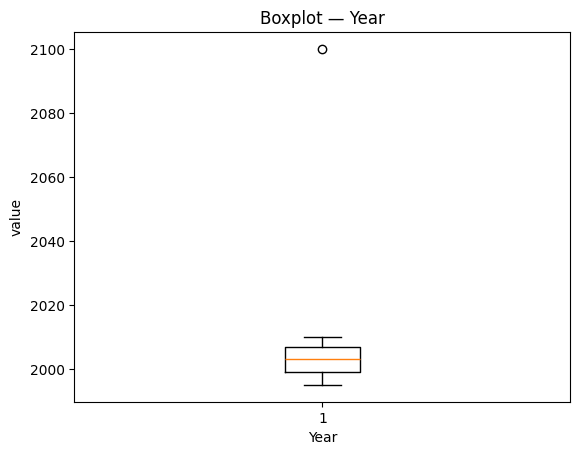

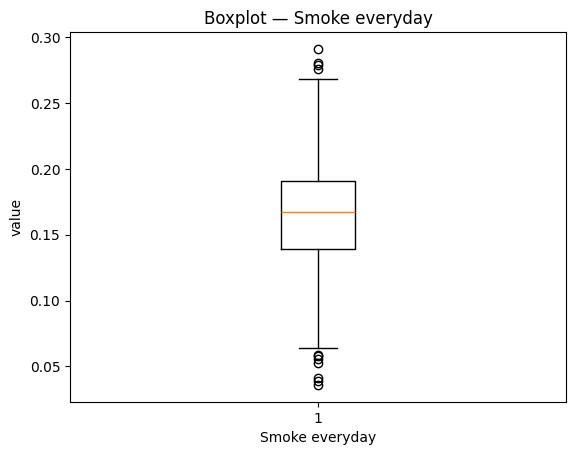

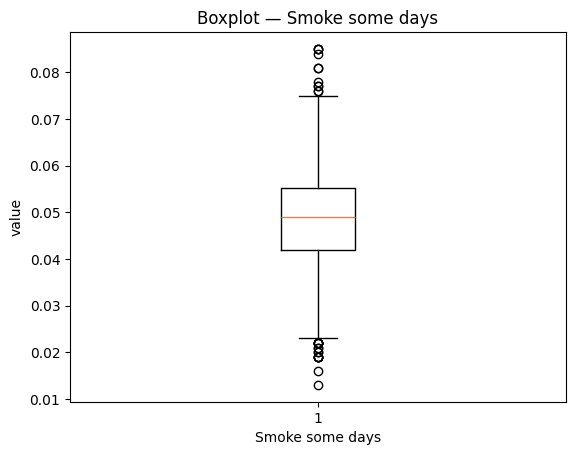

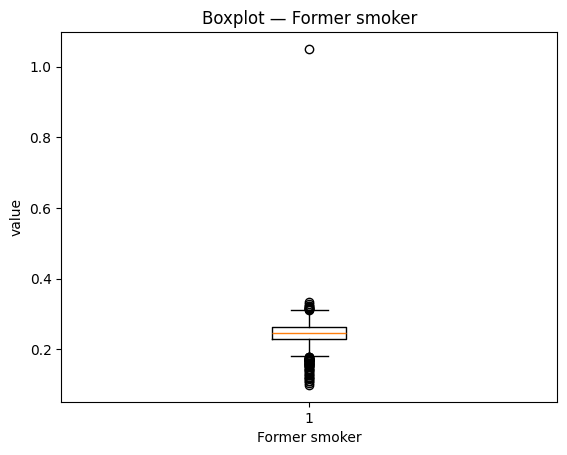

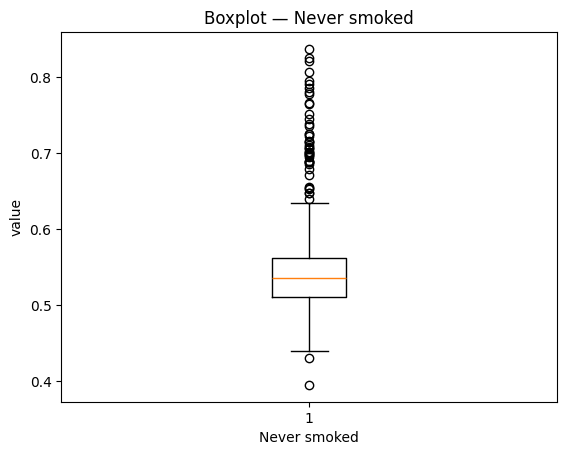

In [26]:
df = pd.read_csv("cleaned_smoke.csv")  # your cleaned data

# Example: drop rows with outliers
df_drop = treat_outliers(df, policy="drop_rows")
print("Original shape:", df.shape, "-> after drop:", df_drop.shape)

# Example: clip values
df_clip = treat_outliers(df, policy="clip")

# Example: log transform
df_log = treat_outliers(df, policy="log")

# Example: standardize
df_std = treat_outliers(df, policy="standardize")

# Example: plot
plot_box(df)


